<a href="https://colab.research.google.com/github/amirhoseinaghaei/Research_Simulation/blob/main/Research_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!fusermount -u drive
!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/drive: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/') 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
%cd gdrive/MyDrive/Research_Simmulation/


/content/gdrive/MyDrive/Research_Simmulation


In [5]:

import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750
deadline = 40
Lesson_buffer_a0 = LessonBuffer(1000, deadline, 5)
episode = 0
rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
# rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_120_send_0.1.pt.pt'))
environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(5000)):
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'
# if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
    while not done:
        action = 1
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.U > 0:
            action = 0
        # if environment.sendbackaction == True:
        #     action = 1

        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if rewards[-1] == 0 and len(res) > 0 :
              rewards[-1] = sum(rewards)
              rewards[-1] = rewards[-1]/20
              rewards[res[0]] = 0
            else:
              rewards[-1] = rewards[-1]/20
               
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            # print(states)
            # print(actions)
            # print(rewards)
            Lesson_buffer_a0.add(states = states, actions = actions, rewards = rewards)
            if  episode < 2500 and Lesson_buffer_a0.full_enough() and Lesson_buffer_a0.different_returns_encountered()  :
                    if episode % 25 == 0:

                        print(episode)
                        rudder_lstm_a0.train(episode=episode)
                    if episode >= 1800: 
                        torch.save(rudder_lstm_a0.state_dict(), 'rudder_lstm_150_send_0.4.pt')

            rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
          
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] , keys[1] , policy_updator.Quality[keys[0] ,keys[1]]))
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

[[0.4, 0.6], [0.5, 0.5]]
[[0.4, 0.6], [0.5, 0.5]]
402108


  5%|▌         | 272/5000 [00:05<01:38, 48.01it/s]

275


  6%|▌         | 299/5000 [03:15<4:20:40,  3.33s/it]

300


  6%|▋         | 321/5000 [03:21<1:57:59,  1.51s/it]

325


  7%|▋         | 341/5000 [03:22<58:38,  1.32it/s]  

350


  7%|▋         | 373/5000 [03:37<33:59,  2.27it/s]

375


  8%|▊         | 399/5000 [04:35<1:18:10,  1.02s/it]

400


  8%|▊         | 413/5000 [05:18<1:58:48,  1.55s/it]

425


  9%|▉         | 443/5000 [05:19<40:14,  1.89it/s]

450


  9%|▉         | 474/5000 [05:36<30:37,  2.46it/s]

475


 10%|▉         | 493/5000 [05:37<17:34,  4.28it/s]

500


 10%|█         | 523/5000 [06:44<1:17:06,  1.03s/it]

525


 11%|█         | 542/5000 [06:45<40:57,  1.81it/s]

550


 11%|█▏        | 569/5000 [07:10<42:54,  1.72it/s]  

575


 12%|█▏        | 591/5000 [07:11<20:32,  3.58it/s]

600


 12%|█▏        | 624/5000 [07:16<11:41,  6.24it/s]

625


 13%|█▎        | 649/5000 [07:30<19:33,  3.71it/s]

650


 13%|█▎        | 668/5000 [07:31<11:57,  6.04it/s]

675


 14%|█▍        | 698/5000 [07:32<05:03, 14.17it/s]

700


 14%|█▍        | 724/5000 [19:11<12:18:53, 10.37s/it]

725


 15%|█▍        | 749/5000 [22:16<7:38:50,  6.48s/it] 

750


 15%|█▌        | 763/5000 [22:49<4:59:01,  4.23s/it]

775


 16%|█▌        | 793/5000 [22:50<1:37:11,  1.39s/it]

800


 16%|█▋        | 819/5000 [22:51<36:38,  1.90it/s]

825


 17%|█▋        | 848/5000 [22:58<19:11,  3.61it/s]

850


 17%|█▋        | 868/5000 [23:08<23:22,  2.95it/s]

875


 18%|█▊        | 896/5000 [23:09<09:29,  7.20it/s]

900


 18%|█▊        | 924/5000 [23:13<08:15,  8.23it/s]

925


 19%|█▉        | 942/5000 [23:14<05:21, 12.63it/s]

950


 19%|█▉        | 970/5000 [23:15<02:54, 23.09it/s]

975


 20%|█▉        | 998/5000 [23:16<02:11, 30.54it/s]

1000


 20%|██        | 1022/5000 [23:17<02:11, 30.36it/s]

1025


 21%|██        | 1045/5000 [23:18<02:22, 27.74it/s]

1050


 21%|██▏       | 1068/5000 [23:19<02:23, 27.35it/s]

1075


 22%|██▏       | 1095/5000 [23:24<05:46, 11.28it/s]

1100


 22%|██▏       | 1123/5000 [23:31<08:51,  7.29it/s]

1125


 23%|██▎       | 1149/5000 [23:32<04:46, 13.46it/s]

1150


 23%|██▎       | 1174/5000 [23:33<03:15, 19.58it/s]

1175


 24%|██▍       | 1193/5000 [23:34<03:04, 20.66it/s]

1200


 24%|██▍       | 1213/5000 [23:35<02:31, 24.98it/s]

1225


 25%|██▍       | 1246/5000 [23:36<01:44, 36.05it/s]

1250


 25%|██▌       | 1274/5000 [23:37<01:41, 36.69it/s]

1275


 26%|██▌       | 1292/5000 [23:41<05:49, 10.61it/s]

1300


 26%|██▋       | 1319/5000 [23:42<03:02, 20.18it/s]

1325


 27%|██▋       | 1347/5000 [23:43<02:24, 25.32it/s]

1350


 27%|██▋       | 1373/5000 [23:44<02:01, 29.91it/s]

1375


 28%|██▊       | 1399/5000 [23:45<02:14, 26.68it/s]

1400


 28%|██▊       | 1422/5000 [23:47<02:30, 23.75it/s]

1425


 29%|██▉       | 1448/5000 [24:00<13:52,  4.27it/s]

1450


 29%|██▉       | 1466/5000 [24:01<08:11,  7.18it/s]

1475


 30%|██▉       | 1495/5000 [24:02<03:35, 16.25it/s]

1500


 30%|███       | 1522/5000 [24:03<02:11, 26.42it/s]

1525


 31%|███       | 1549/5000 [24:03<01:41, 33.97it/s]

1550


 31%|███▏      | 1567/5000 [24:04<01:49, 31.41it/s]

1575


 32%|███▏      | 1594/5000 [24:08<04:00, 14.14it/s]

1600


 32%|███▏      | 1619/5000 [24:12<05:53,  9.58it/s]

1625


 33%|███▎      | 1643/5000 [24:13<03:17, 16.98it/s]

1650


 33%|███▎      | 1670/5000 [24:14<02:09, 25.62it/s]

1675


 34%|███▍      | 1698/5000 [24:15<01:33, 35.32it/s]

1700


 34%|███▍      | 1716/5000 [24:16<01:56, 28.26it/s]

1725


 35%|███▍      | 1745/5000 [24:17<01:29, 36.32it/s]

1750


 35%|███▌      | 1774/5000 [24:18<01:17, 41.62it/s]

1775


 36%|███▌      | 1793/5000 [24:19<01:43, 31.02it/s]

1800


 36%|███▋      | 1821/5000 [24:20<01:38, 32.25it/s]

1825


 37%|███▋      | 1846/5000 [24:21<01:38, 32.10it/s]

1850


 37%|███▋      | 1873/5000 [24:33<09:57,  5.24it/s]

1875


 38%|███▊      | 1898/5000 [24:34<03:45, 13.78it/s]

1900


 38%|███▊      | 1922/5000 [24:35<02:12, 23.20it/s]

1925


 39%|███▉      | 1947/5000 [24:36<01:43, 29.44it/s]

1950


 39%|███▉      | 1973/5000 [24:37<01:38, 30.62it/s]

1975


 40%|███▉      | 1994/5000 [24:38<01:42, 29.28it/s]

2000


 40%|████      | 2022/5000 [24:39<01:41, 29.31it/s]

2025


 41%|████      | 2045/5000 [24:40<01:38, 30.09it/s]

2050


 41%|████▏     | 2070/5000 [24:42<01:34, 30.92it/s]

2075


 42%|████▏     | 2096/5000 [24:43<01:24, 34.19it/s]

2100


 42%|████▏     | 2120/5000 [24:44<01:25, 33.65it/s]

2125


 43%|████▎     | 2144/5000 [24:45<01:25, 33.50it/s]

2150


 43%|████▎     | 2174/5000 [24:46<01:13, 38.48it/s]

2175


 44%|████▍     | 2199/5000 [24:47<01:17, 36.15it/s]

2200


 44%|████▍     | 2221/5000 [24:48<01:29, 31.00it/s]

2225


 45%|████▍     | 2244/5000 [24:49<01:28, 30.99it/s]

2250


 45%|████▌     | 2269/5000 [24:50<01:21, 33.51it/s]

2275


 46%|████▌     | 2296/5000 [24:51<01:20, 33.76it/s]

2300


 46%|████▋     | 2320/5000 [24:52<01:31, 29.23it/s]

2325


 47%|████▋     | 2348/5000 [24:53<01:25, 30.99it/s]

2350


 47%|████▋     | 2370/5000 [24:54<01:33, 28.00it/s]

2375


 48%|████▊     | 2398/5000 [24:56<01:27, 29.76it/s]

2400


 48%|████▊     | 2423/5000 [24:57<01:17, 33.18it/s]

2425


 49%|████▉     | 2447/5000 [24:58<01:14, 34.30it/s]

2450


 49%|████▉     | 2471/5000 [24:59<01:19, 31.68it/s]

2475


100%|██████████| 5000/5000 [25:27<00:00,  3.27it/s] 


(80, Ch1, 150, 1, 0)               0               0
(80, Ch1, 150, 1, 0) Wait                          0
(80, Ch1, 150, 1, 0)               1 -35.64038848876953
(80, Ch1, 150, 1, 0) Wait                          0
(80, Ch2, 150, 1, 0)               0               0
(80, Ch2, 150, 1, 0) Wait                          0
(80, Ch2, 150, 1, 0)               1 -56.415679931640625
(80, Ch2, 150, 1, 0) Wait                          0
(81, Ch1, 150, 1, 0)               0               0
(81, Ch1, 150, 1, 0) Wait                          0
(81, Ch1, 150, 1, 0)               1 -31.650983810424805
(81, Ch1, 150, 1, 0) Wait                          0
(81, Ch2, 150, 1, 0)               0               0
(81, Ch2, 150, 1, 0) Wait                          0
(81, Ch2, 150, 1, 0)               1 -55.107330322265625
(81, Ch2, 150, 1, 0) Wait                          0
(82, Ch1, 150, 1, 0)               0               0
(82, Ch1, 150, 1, 0) Wait                          0
(82, Ch1, 150, 1, 0)           

In [ ]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

Lesson_buffer_a1 = LessonBuffer(1000, 25, 5)
episode = 0

rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
# rudder_lstm.load_state_dict(torch.load('rudder_lstm.pt'))
environment = Environment(100,25)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
visited_dict_0 = {}
for i in range(5000):
    episode += 1
    environment.reset_paramter()
    state = environment.reset_state()
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        action = 1 
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            Lesson_buffer_a1.add(states = states, actions = actions, rewards = rewards)
            if  episode < 2000 and Lesson_buffer_a1.full_enough() and Lesson_buffer_a1.different_returns_encountered()  :
                    if episode % 25 == 0:

                        # print("True")
                        print(episode)
                        rudder_lstm_a1.train(episode=episode)
                    if episode >= 1800: 
                        torch.save(rudder_lstm_a1.state_dict(), 'rudder_lstm_send_100.pt')
            rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] ,  keys[1], value))
print("******************************************************************")
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))


[[0.75, 0.25], [0.85, 0.15000000000000002]]
Amir
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875
1900
1925
1950
1975
(31, Ch1, 120, 1, 0)               0               0
(31, Ch1, 120, 1, 0)               1 13.735158920288086
(31, Ch2, 120, 1, 0)               0               0
(31, Ch2, 120, 1, 0)               1 12.685922622680664
(36, Ch1, 50, 1, 0)               0               0
(36, Ch1, 50, 1, 0)               1 5.22218132019043
(36, Ch2, 50, 1, 0)               0               0
(36, Ch2, 50, 1, 0)               1 0.797095775604248
(39, Ch1, 50, 1, 0)               0               0
(39, Ch1, 50, 1, 0)               1 7.4098968505859375
(39, Ch2, 50, 1, 0)               0               0
(39, Ch2, 50, 1, 0)               1 7.559392452

In [6]:



import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm 

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0
Lesson_buffer_a1 = LessonBuffer(1000, 40, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 40, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_150_wait_0.4.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_150_send_0.4.pt'))

environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(10000)):
    episode += 1
    environment.reset_paramter()
    state , _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        if np.random.random() < 0.15:
            action = np.random.choice(2) 
        else:
            action = 0 if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.U > 0:
            action = 0
        if environment.sendbackaction == True:
            action = 1
        state, reward, done = environment.step(action)
    
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
              rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
              rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

[[0.4, 0.6], [0.5, 0.5]]
402108


100%|██████████| 10000/10000 [02:00<00:00, 83.27it/s]


(80, Ch1, 150, 1, 0) Wait            11.59033489227295
(80, Ch1, 150, 1, 0) Wait            11.59033489227295
(80, Ch2, 150, 1, 0) Wait            11.542797088623047
(80, Ch2, 150, 1, 0) Wait            11.542797088623047
(81, Ch1, 150, 1, 0) Wait            11.672056198120117
(81, Ch1, 150, 1, 0) Wait            11.672056198120117
(81, Ch2, 150, 1, 0) Wait            11.406391143798828
(81, Ch2, 150, 1, 0) Wait            11.406391143798828
(82, Ch1, 150, 1, 0) Wait            11.619583129882812
(82, Ch1, 150, 1, 0) Wait            11.619583129882812
(82, Ch2, 150, 1, 0) Wait            11.461328506469727
(82, Ch2, 150, 1, 0) Wait            11.461328506469727
(83, Ch1, 150, 1, 0) Wait            10.877642631530762
(83, Ch1, 150, 1, 0) Wait            10.877642631530762
(83, Ch2, 150, 1, 0) Wait            11.455082893371582
(83, Ch2, 150, 1, 0) Wait            11.455082893371582
(84, Ch1, 150, 1, 0) Wait            11.160425186157227
(84, Ch1, 150, 1, 0) Wait            11.1604251861

 **Finding Optimal policies with DQN** 

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        # if T.cuda.is_available() else 'cpu'
        self.device = T.device('cuda')
        self.to(self.device)

    def forward(self, state):
        state = T.Tensor(state).to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # state = T.tensor(observation).to(self.Q_eval.device)      
            actions = self.Q_eval.forward(observation)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        # print((q_next)[:,0])
        # print(T.max(q_next, dim=1)[0])
        # print((q_next)[:,0])
        # Time.sleep(1)
        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

In [ ]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm
lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0

Lesson_buffer_a1 = LessonBuffer(1000, 40, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 40, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_70_125_wait_0.2.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_70_125_send_0.2.pt'))


DQN_Agent = Agent(gamma=1, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01,
                  input_dims=[5], lr=0.001)

environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(8000)):
    # print(episode)
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])

    rewards = []
    states = [state]
    actions = []
    dones = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'
    # prev_state = state

    initial_state= state
    if initial_state[1] == "Ch1":
        initial_state[1] = 1
    else:
        initial_state[1] = 0
    initial_state = initial_state.astype(int)

    while not done:
   
        action = DQN_Agent.choose_action(initial_state)
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        dones.append(done)
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
              rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
              rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            for i in range(25):
              DQN_Agent.store_transition(states[i], actions[i], rewards[i], states[i+1],
                                  dones[i])
              DQN_Agent.learn()
Optimal_Policy_Dict = {}
for state in environment.initial_State:
  State  =  np.array([state.Au, state.Ch, state.BT, state.Ra, state.U])
  if State[1] == "Ch1":
    State[1] = 1
  else:
    State[1] = 0
  State = State.astype(int) 
  actions =  DQN_Agent.Q_eval.forward(State)

  if State[1] == 1:
    CH_NAME = "Ch1"
  else:
    CH_NAME = "Ch2"
  name = f'({State[0]}, {CH_NAME}, {State[2]}, {State[3]}, {State[4]})'
  action = T.argmax(actions).item()
  if action == 0:
    Optimal_Policy_Dict[name] = "wait"
  else:
    Optimal_Policy_Dict[name] = "send"  
  print(f'{State} ___________________________ {DQN_Agent.Q_eval.forward(State)}')
print(Optimal_Policy_Dict)


<ipython-input-15-3b5fcbbde268>:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


[[0.2, 0.8], [0.30000000000000004, 0.7]]
Amir


  2%|▏         | 164/8000 [00:16<13:01, 10.03it/s]


KeyboardInterrupt: ignored

**optimal policies with Dueling Double DQN** 

In [7]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                    dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class DuelingDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DuelingDeepQNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.fc1 = nn.Linear(*input_dims, 512)
        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        # 
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        flat1 = F.relu(self.fc1(state))
        V = self.V(flat1)
        A = self.A(flat1)

        return V, A

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class Dueling_DDQN_Agent():
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, chkpt_dir='tmp/dueling_ddqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(self.n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims)

        self.q_eval = DuelingDeepQNetwork(self.lr, self.n_actions,
                                   input_dims=self.input_dims,
                                   name='lunar_lander_dueling_ddqn_q_eval',
                                   chkpt_dir=self.chkpt_dir)

        self.q_next = DuelingDeepQNetwork(self.lr, self.n_actions,
                                   input_dims=self.input_dims,
                                   name='lunar_lander_dueling_ddqn_q_next',
                                   chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            _, advantage = self.q_eval.forward(state)
            action = T.argmax(advantage).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                        if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        indices = np.arange(self.batch_size)

        V_s, A_s = self.q_eval.forward(states)
        V_s_, A_s_ = self.q_next.forward(states_)

        V_s_eval, A_s_eval = self.q_eval.forward(states_)

        q_pred = T.add(V_s,
                        (A_s - A_s.mean(dim=1, keepdim=True)))[indices, actions]
        q_next = T.add(V_s_,
                        (A_s_ - A_s_.mean(dim=1, keepdim=True)))

        q_eval = T.add(V_s_eval, (A_s_eval - A_s_eval.mean(dim=1,keepdim=True)))

        max_actions = T.argmax(q_eval, dim=1)
        max_actions[indices] = 0
        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next[indices, max_actions]

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

In [8]:

import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm
lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0
Lesson_buffer_a1 = LessonBuffer(1000, 40, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 40, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_150_wait_0.4.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_150_send_0.4.pt'))


Dueling_Double_DQN_Agent = Dueling_DDQN_Agent(gamma=1, epsilon=1.0, lr=3e-4,
                  input_dims=[5], n_actions=2, mem_size=100000, eps_min=0.01,
                  batch_size=64, eps_dec=1e-3, replace=100)

environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(5000)):
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    dones = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    initial_state= state
    if initial_state[1] == "Ch1":
        initial_state[1] = 1
    else:
        initial_state[1] = 0
    initial_state = initial_state.astype(int)

    while not done:
        action = Dueling_Double_DQN_Agent.choose_action(initial_state)
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        # if environment.state.Ra == 0 and environment.state.U == 19:
        #     action = 1
        if environment.state.U > 0:
            action = 0
        if environment.sendbackaction == True:
           action = 1
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        dones.append(done)
        if done: 
            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              rewards[-1] = rewards[res[0]]
              rewards[-1] = rewards[-1]/20
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
                  rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
                  rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            for i in range(40):
              Dueling_Double_DQN_Agent.store_transition(states[i], actions[i], rewards[i], states[i+1],
                                  dones[i])
              Dueling_Double_DQN_Agent.learn()
Optimal_Policy_Dict = {}
for state in environment.initial_State:
  print(state.Name)
  State  =  np.array([state.Au, state.Ch, state.BT, state.Ra, state.U])
  if State[1] == "Ch1":
    State[1] = 1
  else:
    State[1] = 0
  State = State.astype(int) 
  state = T.tensor([State],dtype=T.float).to(Dueling_Double_DQN_Agent.q_eval.device)
  _, advantage =  Dueling_Double_DQN_Agent.q_eval.forward(state)
  action = T.argmax(advantage).item()
  if State[1] == 1:
    CH_NAME = "Ch1"
  else:
    CH_NAME = "Ch2"
  name = f'({State[0]}, {CH_NAME}, {State[2]}, {State[3]}, {State[4]})'
  if action == 0:
    Optimal_Policy_Dict[name] = "wait"
  else:
    Optimal_Policy_Dict[name] = "send"  
  print(f'{State} __________________ {advantage}_________________{action}')
print(Optimal_Policy_Dict)

[[0.4, 0.6], [0.5, 0.5]]
402108


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-7-1b663948e460>:163: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1646.)
  q_next[dones] = 0.0
/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:197: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1646.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-7-1b663948e460>:103: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/t

(80, Ch1, 150, 1, 0)
[ 80   1 150   1   0] __________________ tensor([[-14.7901,  14.9734]], grad_fn=<AddmmBackward0>)_________________1
(80, Ch2, 150, 1, 0)
[ 80   0 150   1   0] __________________ tensor([[-16.1313,  16.6219]], grad_fn=<AddmmBackward0>)_________________1
(81, Ch1, 150, 1, 0)
[ 81   1 150   1   0] __________________ tensor([[-14.3788,  14.6810]], grad_fn=<AddmmBackward0>)_________________1
(81, Ch2, 150, 1, 0)
[ 81   0 150   1   0] __________________ tensor([[-15.7731,  16.3832]], grad_fn=<AddmmBackward0>)_________________1
(82, Ch1, 150, 1, 0)
[ 82   1 150   1   0] __________________ tensor([[-14.0971,  14.4678]], grad_fn=<AddmmBackward0>)_________________1
(82, Ch2, 150, 1, 0)
[ 82   0 150   1   0] __________________ tensor([[-15.6494,  16.3153]], grad_fn=<AddmmBackward0>)_________________1
(83, Ch1, 150, 1, 0)
[ 83   1 150   1   0] __________________ tensor([[-14.0012,  14.4121]], grad_fn=<AddmmBackward0>)_________________1
(83, Ch2, 150, 1, 0)
[ 83   0 150   1   0

In [ ]:



import numpy as np
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

Lesson_buffer = LessonBuffer(1000, 25, 5)
episode = 0
rudder_lstm = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
# rudder_lstm.load_state_dict(torch.load('rudder_lstm.pt'))
environment = Environment(100,25)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in range(2050):
    episode += 1
    environment.reset_paramter()
    state = environment.reset_state()
    rewards = []
    states = [state]
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        action = 0 if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            Lesson_buffer.add(states = states, actions = actions, rewards = rewards)
            if  episode < 5000 and Lesson_buffer.full_enough() and Lesson_buffer.different_returns_encountered()  :
                    if episode % 25 == 0:

                        print(episode)
                        rudder_lstm.train(episode=episode)
                    if episode >= 1800: 
                        torch.save(rudder_lstm.state_dict(), 'rudder_lstm_120.pt')

            rewards = rudder_lstm.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] ,  keys[1], value))

print("******************************************************************")
Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

In [ ]:
!pip install PyQt5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 KB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 10.7 MB/s eta 0:00:00


In [4]:
import json
 
# Opening JSON file
with open('Optimal_Policy_Qlearning_0.1_120_150.json') as json_file:
    Optimal_Policy_Dict = json.load(json_file)

In [ ]:
import json
with open("Optimal_Policy_Qlearning_0.1_120.json", "w") as write_file:
    json.dump(Optimal_Policy_Dict, write_file, indent=4)

[[0.1, 0.9], [0.2, 0.8]]
402108
['152' 'Ch2' '150' '1' '0']
['151' 'Ch1' '150' '1' '0']
['222' 'Ch1' '150' '1' '0']
['288' 'Ch2' '150' '1' '0']
['92' 'Ch2' '150' '1' '0']
['345' 'Ch2' '150' '1' '0']
['283' 'Ch2' '150' '1' '0']
['218' 'Ch2' '150' '1' '0']
['276' 'Ch1' '150' '1' '0']
['218' 'Ch2' '150' '1' '0']
['221' 'Ch2' '150' '1' '0']
['150' 'Ch1' '150' '1' '0']
['158' 'Ch1' '150' '1' '0']
['147' 'Ch2' '150' '1' '0']
['282' 'Ch2' '150' '1' '0']
['354' 'Ch2' '150' '1' '0']
['276' 'Ch2' '150' '1' '0']
['215' 'Ch1' '150' '1' '0']
['159' 'Ch2' '150' '1' '0']
['218' 'Ch2' '150' '1' '0']
['82' 'Ch2' '150' '1' '0']
['149' 'Ch2' '150' '1' '0']
['353' 'Ch2' '150' '1' '0']
['156' 'Ch2' '150' '1' '0']
['88' 'Ch2' '150' '1' '0']
['214' 'Ch1' '150' '1' '0']
['348' 'Ch2' '150' '1' '0']
['222' 'Ch1' '150' '1' '0']
['276' 'Ch1' '150' '1' '0']
['80' 'Ch2' '150' '1' '0']
['85' 'Ch1' '150' '1' '0']
['355' 'Ch2' '150' '1' '0']
['216' 'Ch2' '150' '1' '0']
['281' 'Ch1' '150' '1' '0']
['151' 'Ch2' '150' '1

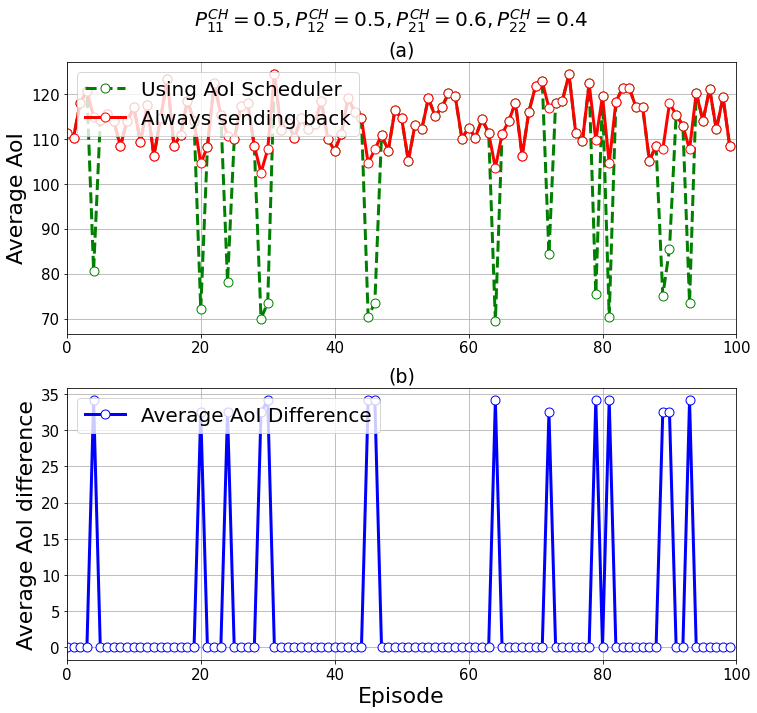

In [7]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from matplotlib import pyplot as plt
from StateDto import State


lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750
UseOptimalPolicy = True
episode = 0
NUM_EPISODE = 100
deadline = 40
environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
Total_Reward_List = []
Total_Reward_List_Without_Optimal_Policy = []

for i in range(NUM_EPISODE):
    environment.reset_paramter()
    state , fixed_State = environment.reset_state()
    first_state = state
    print(first_state)
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    episode += 1
    rewards = []
    states = [first_state]
    Episode_AoI = [first_state[0]]
    actions = []
    done = False
    name = f'({first_state[0]}, {first_state[1]}, {first_state[2]}, {first_state[3]}, {first_state[4]})'

    while not done:
        action = 1
        if environment.state.Ra == 0 and environment.state.U == 0:
          action = 0
        if environment.state.U > 0:
          action = 0
          
        state, reward, done = environment.step(action)
        Episode_AoI.append(state[0])
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 
          Episode_AoI = [int(i) for i in Episode_AoI]
          Total_Reward_List_Without_Optimal_Policy.append(sum(Episode_AoI)/deadline)
    rewards = []
    states = [first_state]
    Episode_AoI = [first_state[0]]
    actions = []
    done = False
    environment.reset_paramter()
    environment.state = State(name, int(first_state[0]), (first_state[1]), int(first_state[2]), int(first_state[3]), int(first_state[4]))
    while not done:
        if UseOptimalPolicy:
          action  = 0 if Optimal_Policy_Dict[name] == 'wait' else 1 
          # print(Optimal_Policy_Dict[name])
        # else:
        #   action = 1 
        if environment.state.Ra == 0 and environment.state.U == 0:
          action = 0
        # if environment.state.Ra == 0 and environment.state.U == 24:
        #   action = 1
        if environment.state.U > 0:
          action = 0
        if environment.sendbackaction == True:
          action = 1
        state, reward, done = environment.step(action)

        Episode_AoI.append(state[0])
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 
          Episode_AoI = [int(i) for i in Episode_AoI]
          Total_Reward_List.append(sum(Episode_AoI)/deadline)


fig, ax = plt.subplots(2,figsize=(12,11))


AVerageAoIUsingScheduler = [sum(Total_Reward_List)/NUM_EPISODE for i in range(NUM_EPISODE)]
AVerageAoIWithoutScheduler = [sum(Total_Reward_List_Without_Optimal_Policy)/NUM_EPISODE for i in range(NUM_EPISODE)]

AoI_Difference_List = [Total_Reward_List_Without_Optimal_Policy[i] - Total_Reward_List[i] for i in range(len(Total_Reward_List_Without_Optimal_Policy)) ]

ax[1].plot(AoI_Difference_List, label ='Average AoI Difference', color = "b" ,mec = 'b', mfc = 'w', marker='.', markersize = 18, linestyle = "solid", linewidth = 3)

ax[0].plot(Total_Reward_List, label ='Using AoI Scheduler', color = "g" ,mec = 'g', mfc = 'w', marker='.', markersize = 18, linestyle = "dashed", linewidth = 3)
ax[0].plot(Total_Reward_List_Without_Optimal_Policy, label ='Always sending back' , mec = 'r', mfc = 'w', color = "r", marker='.', markersize = 18,  linestyle = "solid", linewidth = 3)
# for i in range(len(Total_Reward_List)):
#     if AoI_Difference_List[i] == 0:
#         color = 'black'  # set the marker color to red if the values are equal
#         ax[1].plot(i, AoI_Difference_List[i], label ='Send decision', color=color, marker='o', markersize=5)
# for i in range(len(Total_Reward_List)):
#     if AoI_Difference_List[i] != 0:
#         color = 'yellow'  # set the marker color to red if the values are equal
#         ax[1].plot(i, AoI_Difference_List[i], label ='Wait decision', color=color, marker='o', markersize=5)


# ax.plot(AVerageAoIUsingScheduler, label ='Average AoI of 100 Episodes Using AoI Scheduler', color = "g" , markersize = 5, linestyle = "dashed", linewidth = 3)
# ax.plot(AVerageAoIWithoutScheduler, label ='Average AoI of 100 Episodes without AoI Scheduler' , color = "r", markersize = 5,  linestyle = "dashed", linewidth = 3)

ax[0].legend(fontsize = 20, loc='upper left')
ax[1].legend(fontsize = 20, loc='upper left')
handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax[1].legend(by_label.values(), by_label.keys(), loc='upper left')

ax[0].grid()
ax[1].grid()
ax[0].set_ylabel("Average AoI", fontsize = 22.0)
ax[0].set_xlim(xmin=0, xmax=100)
ax[1].set_xlabel("Episode", fontsize = 22.0)
ax[1].set_ylabel("Average AoI difference", fontsize = 22.0)
ax[1].set_xlim(xmin=0, xmax=100)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
string = "$P^{CH}_{11}$$ = 0.5, $$P^{CH}_{12}$$ = 0.5, $$P^{CH}_{21}$$ = 0.6, $$P^{CH}_{22}$$ = 0.4$"
fig.suptitle(string, fontweight ="bold" , y = 0.95, fontsize = 20) 
ax[0].set_title('(a)' , fontsize = 19)
ax[1].set_title('(b)', fontsize = 19)
fig.savefig('SimulationResult_DDDQN_70_125_0.5_0.5.pdf')  

print(f"Average AoI of each episode with AoI scheduler: {sum(Total_Reward_List)/NUM_EPISODE}")
print(f"Average AoI of each episode when DT always send DT data back at request arrival: {sum(Total_Reward_List_Without_Optimal_Policy)/NUM_EPISODE}")
print(f"Average AoI diiference: {sum(AoI_Difference_List)/NUM_EPISODE}")

number_of_optimal_actions = 0
for i in AoI_Difference_List:
  if i > 0 or i < 0:
      number_of_optimal_actions += 1 
print(f"Accuracy is {(number_of_optimal_actions/len(AoI_Difference_List))*100}")


In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-6quk9nlc
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-6quk9nlc
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=18a4bc0ef51d1bb689e4ada74554f25c329c21c2904d8e379fd707cc2bfc02de
  Stored in directory: /tmp/pip-ephem-wheel-cache-nlyq_c0t/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin


created output directory at /content/src
Out bin /content/result.out
